In [98]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import matthews_corrcoef, mean_absolute_error, roc_curve, auc, roc_auc_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
import seaborn as sns
sns.set_theme(context='notebook')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE

import itertools
import os 
os.chdir('e:/ml_data/kaggle_data/insurance_cross_selling')

In [99]:
train = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [100]:
train.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [101]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.000,0,1-2 Year,Yes,65101.000,124.000,187,0
1,Male,43,1,28.000,0,> 2 Years,Yes,58911.000,26.000,288,1
2,Female,25,1,14.000,1,< 1 Year,No,38043.000,152.000,254,0
3,Female,35,1,1.000,0,1-2 Year,Yes,2630.000,156.000,76,0
4,Female,36,1,15.000,1,1-2 Year,No,31951.000,152.000,294,0


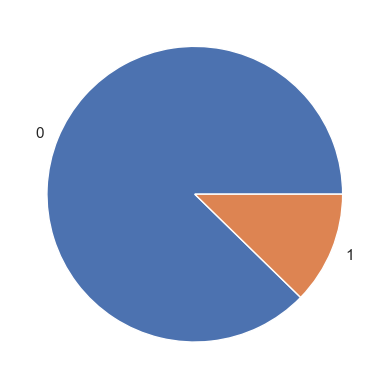

In [102]:
plt.pie(train['Response'].value_counts(), labels=([0, 1]))
plt.show()

In [103]:
train.select_dtypes(include=['object']).nunique()

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

In [104]:
or_encoder = OrdinalEncoder(dtype=int)
train[['Vehicle_Damage', 'Gender']] = or_encoder.fit_transform(train[['Vehicle_Damage', 'Gender']])
test[['Vehicle_Damage', 'Gender']] = or_encoder.transform(test[['Vehicle_Damage', 'Gender']])

In [105]:
train['Vehicle_Age'] = train['Vehicle_Age'].astype('category')
train = pd.get_dummies(train, columns=['Vehicle_Age'])

In [106]:
test = pd.get_dummies(test, columns=['Vehicle_Age'])

In [107]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
id,,,,,,,,,,,,,
0,1,21,1,35.000,0,1,65101.000,124.000,187,0,True,False,False
1,1,43,1,28.000,0,1,58911.000,26.000,288,1,False,False,True
2,0,25,1,14.000,1,0,38043.000,152.000,254,0,False,True,False
3,0,35,1,1.000,0,1,2630.000,156.000,76,0,True,False,False
4,0,36,1,15.000,1,0,31951.000,152.000,294,0,True,False,False


In [108]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
id,,,,,,,,,,,,
11504798,0,20,1,47.000,0,0,2630.000,160.000,228,False,True,False
11504799,1,47,1,28.000,0,1,37483.000,124.000,123,True,False,False
11504800,1,47,1,43.000,0,1,2630.000,26.000,271,True,False,False
11504801,0,22,1,47.000,1,0,24502.000,152.000,115,False,True,False
11504802,1,51,1,19.000,0,0,34115.000,124.000,148,True,False,False


In [109]:
X_train, y_train = train.drop('Response', axis=1), train['Response']

In [110]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [111]:
X_train_smote.shape[0] /  X_train.shape[0]

1.7540054158273792

In [126]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
# data_scaled = scaler.fit_transform(train)

In [113]:
x_train, x_test, y_train, y_test = train_test_split(X_train_scaled, y_train_smote, test_size=0.3, random_state=42)

In [114]:
def model_prediction(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:, 1]

    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    c = precision_score(y_test,x_test_pred)
    d = recall_score(y_test,x_test_pred)
    e = roc_auc_score(y_test, y_test_prob)
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print(f"Precision Score of {model} model is:",c)
    print(f"Recall Score of {model} model is:",d)
    print(f"AUC Score of {model} model is:", e)
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    # plt.figure(figsize=(8,4))
    # sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
    # plt.show()

    return model, cm


In [115]:
model_prediction(LogisticRegression())

Accuracy_Score of LogisticRegression() model on Training Data is: 79.74311807880623
Accuracy_Score of LogisticRegression() model on Testing Data is: 79.77407412546475
Precision Score of LogisticRegression() model is: 0.7444871655722581
Recall Score of LogisticRegression() model is: 0.9065660403791559
AUC Score of LogisticRegression() model is: 0.8888855681745146

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression() model is:


(LogisticRegression(),
 array([[2085665,  941667],
        [ 282779, 2743733]], dtype=int64))

In [116]:
model, cm = model_prediction(XGBClassifier())

Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 85.26119960350098
Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, de

<Axes: >

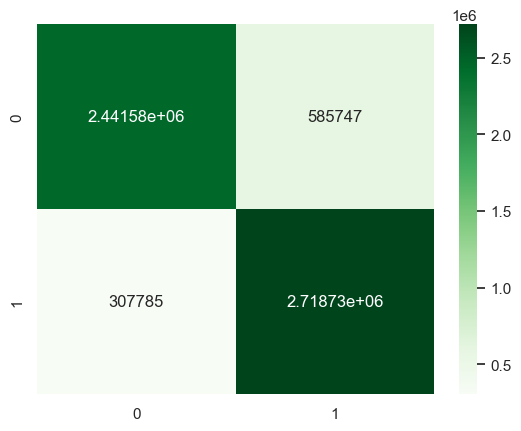

In [117]:
sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")

In [118]:
x_test.shape

(6053844, 12)

In [119]:
test.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'Vehicle_Age_1-2 Year', 'Vehicle_Age_< 1 Year',
       'Vehicle_Age_> 2 Years'],
      dtype='object')

In [124]:
X_train.columns, test.columns

(Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
        'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
        'Vehicle_Age_1-2 Year', 'Vehicle_Age_< 1 Year',
        'Vehicle_Age_> 2 Years'],
       dtype='object'),
 Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
        'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
        'Vehicle_Age_1-2 Year', 'Vehicle_Age_< 1 Year',
        'Vehicle_Age_> 2 Years'],
       dtype='object'))

In [134]:
roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

0.9418162480479804

In [142]:
preds = model.predict_proba(scaler.transform(test))
submission = pd.read_csv('sample_submission.csv')
submission['Response'] = preds[:, 1]
submission.to_csv('./submission.csv', index=False)